In [1]:
GLOBAL_SEED = 7532

from numpy.random import seed
seed(GLOBAL_SEED)
from tensorflow import set_random_seed
set_random_seed(GLOBAL_SEED)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from keras.models import load_model, Sequential
from keras.callbacks import Callback, EarlyStopping, History, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Dense, Dropout, Conv2D, Flatten, MaxPool2D, SpatialDropout2D
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


Read in the data.

In [3]:
train_set = pd.read_csv('train_set_metadata_HMGD.csv')
valid_set = pd.read_csv('valid_set_metadata_HMGD.csv')
test_set = pd.read_csv('test_set_metadata_HMGD.csv')

Initialize constants.

In [3]:
BEST_MODEL_PATH = 'best_model.hdf5'

INPUT_SHAPE = (320, 320, 3)

LEARNING_RATE = 0.0002
N_EPOCHS = 50
BATCH_SIZE = 32

Define the CNN model architecture.

In [4]:
def create_model(input_shape):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=3, activation='elu',padding='same', 
                     input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(SpatialDropout2D(rate=0.25))
    model.add(Conv2D(32, kernel_size=3, activation='elu', padding='same'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())

    model.add(Conv2D(64, kernel_size=3, activation='elu', padding='same'))
    model.add(BatchNormalization())
    model.add(SpatialDropout2D(rate=0.25))
    model.add(Conv2D(64, kernel_size=3, activation='elu', padding='same'))    
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())  
    
    model.add(Conv2D(128, kernel_size=3, activation='elu', padding='same'))
    model.add(BatchNormalization())
    model.add(SpatialDropout2D(rate=0.25))
    model.add(Conv2D(128, kernel_size=3, activation='elu', padding='same'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())
 
    model.add(Conv2D(256, kernel_size=3, activation='elu', padding='same'))
    model.add(BatchNormalization())
    model.add(SpatialDropout2D(rate=0.25))
    model.add(Conv2D(256, kernel_size=3, activation='elu', padding='same'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())
    
    model.add(Conv2D(512, kernel_size=3, activation='elu', padding='same'))
    model.add(BatchNormalization())
    model.add(SpatialDropout2D(rate=0.25))
    model.add(Conv2D(512, kernel_size=3, activation='elu', padding='same'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())

    model.add(Conv2D(1024, kernel_size=3, activation='elu', padding='same'))
    model.add(BatchNormalization())
    model.add(SpatialDropout2D(rate=0.25))
    model.add(Conv2D(1024, kernel_size=3, activation='elu', padding='same'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(rate=0.5, seed=GLOBAL_SEED))
    model.add(Dense(units=512, activation='elu'))
    model.add(Dropout(rate=0.5, seed=GLOBAL_SEED))
    model.add(Dense(units=256, activation='elu'))
    model.add(Dropout(rate=0.5, seed=GLOBAL_SEED))
    model.add(Dense(units=1, activation='relu'))
    
    return model

In [5]:
model = create_model(INPUT_SHAPE)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 320, 320, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 320, 320, 32)      128       
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 320, 320, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 320, 320, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 160, 160, 32)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 160, 160, 32)      128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 160, 160, 64)      18496     
__________

Train the model.

In [6]:
# Create and compile the model
adam = Adam(
    lr=LEARNING_RATE
)
model.compile(
    optimizer=adam, 
    loss='mean_squared_error', 
    metrics=['mean_absolute_error']
)

# Initialize callbacks
checkpoint = ModelCheckpoint(
    'regression_epoch_{epoch:03d}.hdf5', 
    monitor='val_loss', 
    save_best_only=False, 
    save_weights_only=False
)
lr_reduction = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=4
)
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10
)    
callback_list = [checkpoint, lr_reduction, early_stopping]

# generate and augment training and validation data
data_generator = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    horizontal_flip=True  
)
train_data_generator = data_generator.flow_from_dataframe(
    dataframe=train_set, 
    directory='imdb_crop/_all_photos/',
    x_col='photo_path',
    y_col='age',
    target_size=(320, 320),
    class_mode='other',
    batch_size=BATCH_SIZE,
    seed=GLOBAL_SEED
)
valid_data_generator = data_generator.flow_from_dataframe(
    dataframe=valid_set, 
    directory='imdb_crop/_all_photos/',
    x_col='photo_path',
    y_col='age',
    target_size=(320, 320),
    class_mode='other',
    batch_size=BATCH_SIZE,
    seed=GLOBAL_SEED
)

train_steps_per_epoch = train_data_generator.n//train_data_generator.batch_size
valid_steps_per_epoch = valid_data_generator.n//valid_data_generator.batch_size

#fit the model
history = model.fit_generator(
    generator=train_data_generator,
    steps_per_epoch=train_steps_per_epoch, 
    epochs=N_EPOCHS,
    callbacks=callback_list,
    validation_data=valid_data_generator,
    validation_steps=valid_steps_per_epoch,
    workers=4, 
    verbose=1
)

Found 165400 images.
Found 4176 images.
Epoch 1/50
5168/5168 [==============================] - 4851s 939ms/step - loss: 166.1029 - mean_absolute_error: 10.1849 - val_loss: 203.6506 - val_mean_absolute_error: 10.9799
Epoch 2/50
5168/5168 [==============================] - 4827s 934ms/step - loss: 137.6731 - mean_absolute_error: 9.3066 - val_loss: 159.6387 - val_mean_absolute_error: 9.9683
Epoch 3/50
5168/5168 [==============================] - 4861s 941ms/step - loss: 124.9294 - mean_absolute_error: 8.8365 - val_loss: 148.3950 - val_mean_absolute_error: 9.4536
Epoch 4/50
5168/5168 [==============================] - 4836s 936ms/step - loss: 115.8081 - mean_absolute_error: 8.4682 - val_loss: 131.3879 - val_mean_absolute_error: 8.8743
Epoch 5/50
5168/5168 [==============================] - 4836s 936ms/step - loss: 108.0711 - mean_absolute_error: 8.1396 - val_loss: 125.2784 - val_mean_absolute_error: 8.6649
Epoch 6/50
5168/5168 [==============================] - 4836s 936ms/step - loss: 10

Epoch 48/50
5168/5168 [==============================] - 4819s 932ms/step - loss: 56.1273 - mean_absolute_error: 5.6316 - val_loss: 78.0786 - val_mean_absolute_error: 6.4863
Epoch 49/50
5168/5168 [==============================] - 4820s 933ms/step - loss: 56.0045 - mean_absolute_error: 5.6209 - val_loss: 82.4630 - val_mean_absolute_error: 6.6237
Epoch 50/50
5168/5168 [==============================] - 4820s 933ms/step - loss: 55.5825 - mean_absolute_error: 5.6071 - val_loss: 82.4036 - val_mean_absolute_error: 6.6222


Evaluate the model on the test set.

In [7]:
evaluation_data_generator = ImageDataGenerator().flow_from_dataframe(
    dataframe=test_set, 
    directory='imdb_crop/_all_photos/',
    x_col='photo_path',
    y_col='age',
    target_size=(320, 320),
    class_mode='other',
    batch_size=1,
    seed=GLOBAL_SEED,
    shuffle=False
)

best_model = load_model('regression_epoch_044.hdf5')
best_model.evaluate_generator(generator=evaluation_data_generator, steps=len(test_set))

Found 7621 images.


[80.39331507821846, 6.444037773683931]

**Visual inspection of predictions and actual values**

In [10]:
X_test = np.load('test_set_hmgd_arr.npy')
age_preds = best_model.predict(255 * X_test).ravel()

# free up memory
del X_test

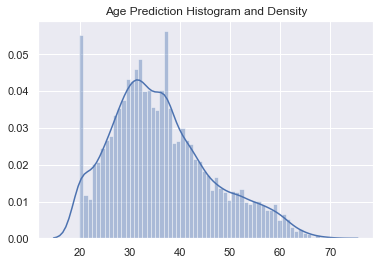

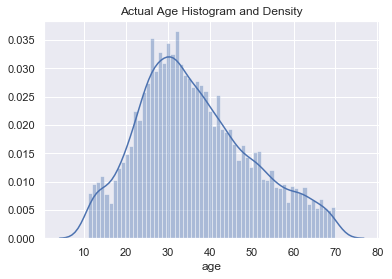

In [19]:
sns.distplot(age_preds, bins=60)
plt.title('Age Prediction Histogram and Density')
plt.show()

sns.distplot(test_set['age'], bins=60)
plt.title('Actual Age Histogram and Density')
plt.show()

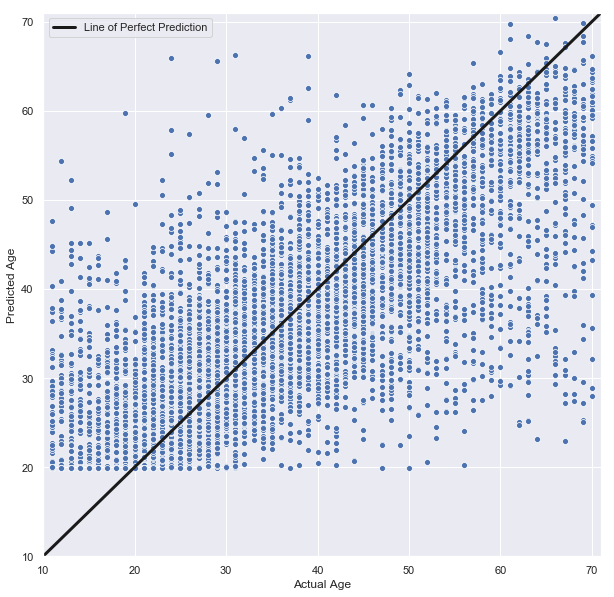

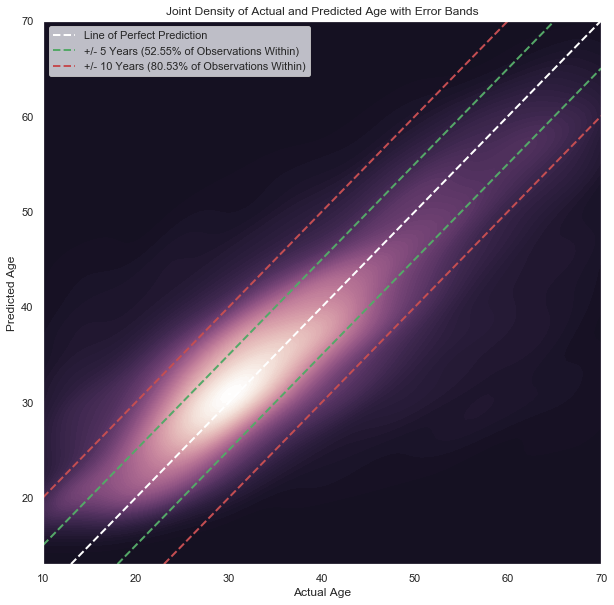

In [83]:
#Scatterplot
plt.figure(figsize=(10, 10))
plt.plot([10, 71], [10, 71], 'k', linewidth=3, label='Line of Perfect Prediction')
sns.scatterplot(test_set['age'].values, age_preds)
plt.xlim((10, 71))
plt.ylim((10, 71))
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.legend()
plt.show()


#Density plot with error bands
within_5_years = (np.abs(age_preds - test_set['age'].values) <=5).mean()
within_5_years = np.round(100 * within_5_years, 2)
within_10_years = (np.abs(age_preds - test_set['age'].values) <=10).mean()
within_10_years = np.round(100 * within_10_years, 2)

plt.figure(figsize=(10, 10))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0.075, light=1, reverse=True)
sns.kdeplot(test_set['age'].values, age_preds, cmap=cmap, n_levels=100, shade=True, clip=[(10, 70), (10, 70)])

plt.plot([13, 70], [13, 70], 'w--', linewidth=2, label='Line of Perfect Prediction')
plt.plot([10, 65], [15, 70], 'g--', linewidth=2, label=f'+/- 5 Years ({within_5_years}% of Observations Within)')
plt.plot([18, 70], [13, 65], 'g--', linewidth=2)
plt.plot([10, 60], [20, 70], 'r--', linewidth=2, label=f'+/- 10 Years ({within_10_years}% of Observations Within)')
plt.plot([23, 70], [13, 60], 'r--', linewidth=2)

plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.legend(loc='upper left')
plt.title('Joint Density of Actual and Predicted Age with Error Bands')
plt.show()